# Dependency on population size

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from os.path import join
import sys
import h5py
import pandas as pd
import pickle
from time import time
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('classic')
from tqdm import tqdm
from scipy.io import loadmat
from utils import *

/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
ROOT = join('/home','ansuini','repos','Decoding')
sys.path.append(join(ROOT))
os.chdir(join(ROOT,'notebooks') )
results_folder = join(ROOT, 'results')

In [4]:
stimFeatures = parseContinuousStimFeatures()
print(stimFeatures.keys())

dict_keys(['area', 'posx', 'orientation', 'eccentricity', 'posy', 'luminosity'])


# Parameters

In [5]:
nstim = 1440
fraction = 0.2
epsilon = 0.1
nfolds = 5
Cs = np.logspace(-6,-2,20)
param_grid = {'C' : Cs}

# Decoding continuous variable

In [6]:
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

In [7]:
# metric
from metrics import pearson
def my_scorer(y_true, y_predicted):
    return pearson(y_true,y_predicted)[0]

In [8]:
def computePerformance(X,y,param_grid,
                       epsilon=epsilon,
                       fraction=fraction,
                       nfolds=nfolds,
                       njobs=1,
                       nprocs=1):
    
    # define basis classifier
    clf_ = SVR(kernel='linear',epsilon=epsilon)
    # create scorer
    my_func = make_scorer(my_scorer,greater_is_better=True)
        
    # permutation of the dataset
    perm = np.random.permutation(X.shape[0])
    X = X[perm,:]
    y = y[perm]
    
    # divide intro training and test
    ntest = int(np.floor(nstim*fraction))
    ntrain = nstim-ntest
    XTrain = X[:ntrain,:]
    yTrain = y[:ntrain]
    XTest = X[ntrain:]
    yTest = y[ntrain:]
    
    # scale data
    
    scXTrain = StandardScaler()
    scXTest = StandardScaler()
    scyTrain = StandardScaler()
    scyTest = StandardScaler()
    
    # reshape y to add a singleton dimension
    yTrain = np.reshape(yTrain,(-1,1))
    yTest = np.reshape(yTest,(-1,1))
    
    XTrain = scXTrain.fit_transform(XTrain)
    XTest = scXTest.fit_transform(XTest)
    yTrain = scyTrain.fit_transform(yTrain)
    yTest = scyTest.fit_transform(yTest)
               
    # reshape back
    yTrain = np.squeeze(yTrain)
    yTest = np.squeeze(yTest)
    
    # define the grid search object
    grid_search = GridSearchCV(clf_, 
                    param_grid, 
                    scoring=my_func, 
                    cv=nfolds, 
                    n_jobs=nprocs, 
                    refit=True,
                    return_train_score=True)
    tic = time()
    grid_search.fit(XTrain, yTrain)        
    print('Elapsed : {}'.format(time()-tic))  
    
    # final result : generalization to the test set
    clf = SVR(C=grid_search.best_params_['C'], epsilon=epsilon)
    clf.fit(XTrain,yTrain) 
    yPred = clf.predict(XTest)
   
    return clf, grid_search, yTest, yPred

In [9]:
def plotResults(clf,grid_search,yTest,yPred,nunits,
                exp,area,typeunit,obs,sizepop):
    fig = plt.figure(figsize=(15,15))
    fs = 15
    
    plt.subplot(2,2,1) 
    plt.text(0.1,0.9,'Experiment : ' + exp,fontsize=fs)
    plt.text(0.1,0.8,'Area : ' + area,fontsize=fs)
    plt.text(0.1,0.7,'Type of Unit : ' + typeunit,fontsize=fs)
    plt.text(0.1,0.6,'N.of units : ' + str(nunits),fontsize=fs)
    plt.text(0.1,0.4,'Observable : ' + obs,fontsize=fs)
    
    
    plt.subplot(2,2,2)
    Cs = grid_search.param_grid['C']
    mean_test_score = grid_search.cv_results_['mean_test_score']
    plt.semilogx(Cs,mean_test_score,'-o')
    plt.ylabel('score')
    plt.xlabel('C')
    plt.title('Hyperpars search')
    
    plt.subplot(2,2,3)
    
    plt.plot(yTest,yPred,'.b')
    r = pearsonr(yPred,yTest)
    plt.xlabel('y test')
    plt.ylabel('y pred')
    plt.title('Prediction : {} --- corr : {}'.format(obs,np.round(r,3)) )
    
    
    plt.subplot(2,2,4)
    plt.hist(yTest,color='b',label='y test')
    plt.hist(yPred,color='r',label='y pred')
    plt.legend()
    plt.title('Histograms y test, y pred')    
    
    
    plt.savefig(join(ROOT,'notebooks',
                     'test_figures',
            exp + '_' + area + '_' + typeunit + '_' + obs + '.png'))
    plt.show()    

In [10]:
# experimentals,ll,all,posx
exp = 'Experimentals'
area = 'll'
typeunit = 'all'
obs = 'posx'
X = loadFiringRates(exp,area,typeunit)
nunits = X.shape[1]
print(nunits)
y = stimFeatures[obs]

359


In [11]:
popsize = np.array(np.round(np.linspace(10,nunits,20)),dtype=int)
popsize

array([ 10,  28,  47,  65,  83, 102, 120, 139, 157, 175, 194, 212, 230,
       249, 267, 286, 304, 322, 341, 359])

In [12]:
perm = np.random.permutation(X.shape[1])
X = X[:,perm]
R = []
for size in popsize:
    R.append(computePerformance(X[:,:size],y,param_grid))

Elapsed : 2.9721059799194336
Elapsed : 5.074304819107056
Elapsed : 7.4364495277404785
Elapsed : 9.546252012252808
Elapsed : 12.523985147476196
Elapsed : 15.787415742874146
Elapsed : 18.86586308479309
Elapsed : 22.21008586883545
Elapsed : 25.266406536102295
Elapsed : 28.29415774345398
Elapsed : 31.35260534286499
Elapsed : 34.59356498718262
Elapsed : 37.414652824401855
Elapsed : 40.310511350631714
Elapsed : 43.37688732147217
Elapsed : 46.323517084121704
Elapsed : 49.868475914001465
Elapsed : 52.620275020599365
Elapsed : 56.03201413154602
Elapsed : 58.755897521972656


In [13]:
performances = [pearson(r[2],r[3])[0] for r in R]

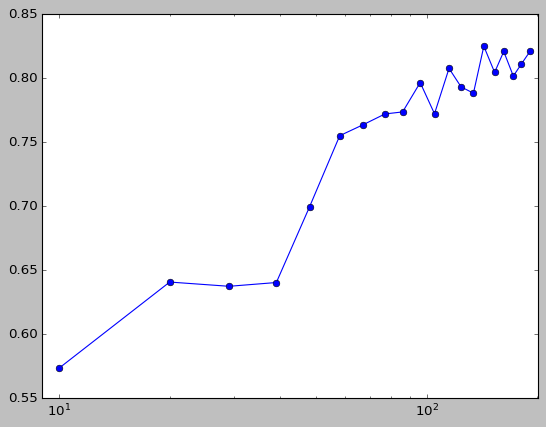

In [24]:
plt.semilogx(popsize, performances,'-bo')
plt.xlim([min(popsize)-1,max(popsize)+10])
plt.show()

In [15]:
# naive,v1 all,posx
exp = 'Naive'
area = 'v1'
typeunit = 'all'
obs = 'posx'
X = loadFiringRates(exp,area,typeunit)
nunits = X.shape[1]
print(nunits)
y = stimFeatures[obs]

191


In [16]:
popsize = np.array(np.round(np.linspace(10,nunits,20)),dtype=int)
popsize

array([ 10,  20,  29,  39,  48,  58,  67,  77,  86,  96, 105, 115, 124,
       134, 143, 153, 162, 172, 181, 191])

In [17]:
perm = np.random.permutation(X.shape[1])
X = X[:,perm]
R = []
for size in popsize:
    R.append(computePerformance(X[:,:size],y,param_grid))
performances = [pearson(r[2],r[3])[0] for r in R]

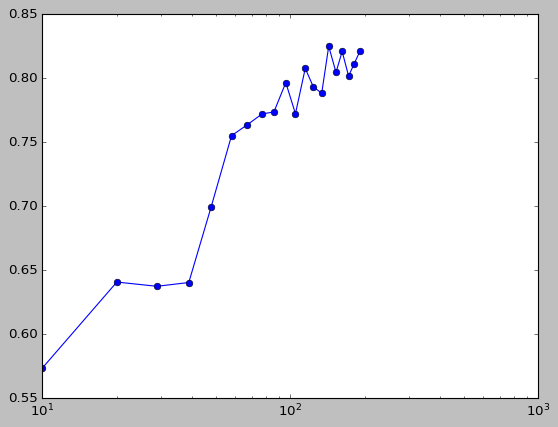

In [19]:
plt.semilogx(popsize, performances,'-bo')
plt.show()

In [ ]:
import h5py
import numpy as np

def build_ppv(db_fname, area, units):
    with h5py.File(db_fname, 'r') as db:
        responses = db[area+'/' + units + '/data/single_trials'][()]
        responses = np.split(responses, responses.shape[1], axis=1)

    indices = []
    for j in range(len(responses)):
        responses[j] = np.squeeze(responses[j])
        responses[j] = np.sort(responses[j].T, axis=0)
        valid_trials = np.logical_not(np.any(np.isnan(responses[j]), axis=1))
        for i in range(responses[j].shape[1]):
            not_nans = np.logical_not(np.isnan(responses[j][:, i]))
            responses[j][not_nans, i] = responses[j][not_nans, i][np.random.permutation(not_nans.sum())]
        responses[j] = responses[j][valid_trials, :]
        indices.append(np.ones(responses[j].shape[0])*j)

    return (np.concatenate(indices), np.concatenate(responses))